# Stock Forecasting with a CNN

## Setup

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [16]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

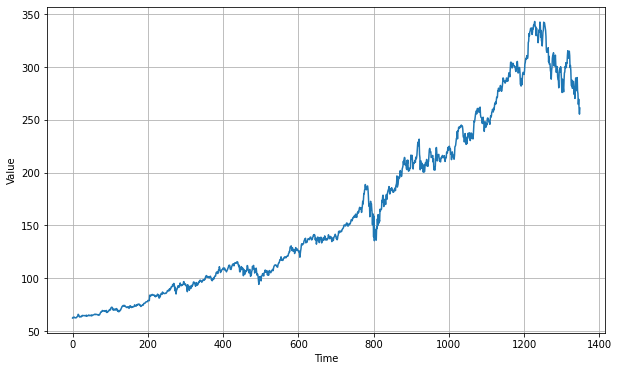

In [4]:
import requests
import pandas as pd

#date and ticker
date = "2022-05-13"
ticker = "MSFT"

response = requests.get("https://eodhistoricaldata.com/api/eod/"+ticker+".US?from=2017-01-05&to="+date+"&period=d&fmt=json&api_token=OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX")
data = response.json()

df = pd.DataFrame(data)
series = df['close']
time = np.arange(len(series))

plt.figure(figsize=(10, 6))
plot_series(time[0:len(series)], series)
plt.show()

In [5]:
split_time = math.floor(.8*len(series))
# split_time = 950
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Fully Convolutional Forecasting

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=64)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1.5e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
17/17 [==============================] - 2s 29ms/step - loss: 131.9481 - mae: 132.4481 - lr: 1.0000e-04
Epoch 2/100
17/17 [==============================] - 0s 12ms/step - loss: 130.1170 - mae: 130.6170 - lr: 1.0798e-04
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 128.4794 - mae: 128.9794 - lr: 1.1659e-04
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 126.1033 - mae: 126.6033 - lr: 1.2589e-04
Epoch 5/100
17/17 [==============================] - 0s 11ms/step - loss: 121.5708 - mae: 122.0708 - lr: 1.3594e-04
Epoch 6/100
17/17 [==============================] - 0s 12ms/step - loss: 112.5180 - mae: 113.0180 - lr: 1.4678e-04
Epoch 7/100
17/17 [==============================] - 0s 11ms/step - loss: 92.8628 - mae: 93.3628 - lr: 1.5849e-04
Epoch 8/100
17/17 [==============================] - 0s 13ms/step - loss: 54.0013 - mae: 54.4996 - lr: 1.7113e-04
Epoch 9/100
17/17 [==============================] - 0s 13ms/step - loss: 37

17/17 [==============================] - 0s 13ms/step - loss: 15.7495 - mae: 16.2437 - lr: 0.0271
Epoch 75/100
17/17 [==============================] - 0s 11ms/step - loss: 6.9636 - mae: 7.4508 - lr: 0.0293
Epoch 76/100
17/17 [==============================] - 0s 11ms/step - loss: 7.3103 - mae: 7.7998 - lr: 0.0316
Epoch 77/100
17/17 [==============================] - 0s 12ms/step - loss: 13.6998 - mae: 14.1926 - lr: 0.0341
Epoch 78/100
17/17 [==============================] - 0s 12ms/step - loss: 41.3195 - mae: 41.8191 - lr: 0.0369
Epoch 79/100
17/17 [==============================] - 0s 11ms/step - loss: 36.3818 - mae: 36.8795 - lr: 0.0398
Epoch 80/100
17/17 [==============================] - 0s 12ms/step - loss: 20.1365 - mae: 20.6301 - lr: 0.0430
Epoch 81/100
17/17 [==============================] - 0s 11ms/step - loss: 18.2086 - mae: 18.7035 - lr: 0.0464
Epoch 82/100
17/17 [==============================] - 0s 12ms/step - loss: 18.0896 - mae: 18.5830 - lr: 0.0501
Epoch 83/100
17/17

(1e-06, 0.1, 0.0, 60.0)

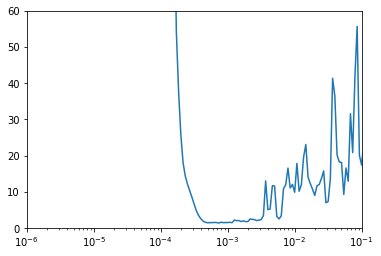

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 60])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=64)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=64)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=3,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=5e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
17/17 [==============================] - 2s 39ms/step - loss: 68.0866 - mae: 68.5851 - val_loss: 49.3405 - val_mae: 49.8383
Epoch 2/500
17/17 [==============================] - 0s 18ms/step - loss: 13.1743 - mae: 13.6621 - val_loss: 11.6586 - val_mae: 12.1500
Epoch 3/500
17/17 [==============================] - 0s 18ms/step - loss: 4.2398 - mae: 4.7090 - val_loss: 9.3330 - val_mae: 9.8212
Epoch 4/500
17/17 [==============================] - 0s 18ms/step - loss: 3.5156 - mae: 3.9808 - val_loss: 7.3914 - val_mae: 7.8771
Epoch 5/500
17/17 [==============================] - 0s 16ms/step - loss: 9.9637 - mae: 10.4502 - val_loss: 26.6199 - val_mae: 27.1197
Epoch 6/500
17/17 [==============================] - 0s 17ms/step - loss: 12.8470 - mae: 13.3431 - val_loss: 32.7867 - val_mae: 33.2867
Epoch 7/500
17/17 [==============================] - 0s 18ms/step - loss: 8.4115 - mae: 8.8978 - val_loss: 17.2048 - val_mae: 17.7024
Epoch 8/500
17/17 [==============================] - 0s 18m

17/17 [==============================] - 0s 22ms/step - loss: 2.4823 - mae: 2.9367 - val_loss: 4.6373 - val_mae: 5.1145
Epoch 63/500
17/17 [==============================] - 0s 22ms/step - loss: 1.7099 - mae: 2.1341 - val_loss: 4.5635 - val_mae: 5.0429
Epoch 64/500
17/17 [==============================] - 0s 22ms/step - loss: 1.6343 - mae: 2.0585 - val_loss: 4.5773 - val_mae: 5.0562
Epoch 65/500
17/17 [==============================] - 0s 22ms/step - loss: 1.6383 - mae: 2.0626 - val_loss: 4.2547 - val_mae: 4.7285
Epoch 66/500
17/17 [==============================] - 0s 22ms/step - loss: 1.6828 - mae: 2.1112 - val_loss: 4.4493 - val_mae: 4.9255
Epoch 67/500
17/17 [==============================] - 0s 22ms/step - loss: 1.7553 - mae: 2.1872 - val_loss: 4.3199 - val_mae: 4.7941
Epoch 68/500
17/17 [==============================] - 0s 21ms/step - loss: 2.5104 - mae: 2.9637 - val_loss: 4.7839 - val_mae: 5.2597
Epoch 69/500
17/17 [==============================] - 0s 22ms/step - loss: 1.6310 

17/17 [==============================] - 1s 30ms/step - loss: 3.2769 - mae: 3.7456 - val_loss: 11.7925 - val_mae: 12.2893
Epoch 124/500
17/17 [==============================] - 1s 29ms/step - loss: 4.0959 - mae: 4.5739 - val_loss: 4.3397 - val_mae: 4.8209
Epoch 125/500
17/17 [==============================] - 1s 28ms/step - loss: 1.9824 - mae: 2.4299 - val_loss: 8.0192 - val_mae: 8.5133
Epoch 126/500
17/17 [==============================] - 1s 29ms/step - loss: 1.5970 - mae: 2.0194 - val_loss: 3.9132 - val_mae: 4.3901
Epoch 127/500
17/17 [==============================] - 1s 28ms/step - loss: 1.4140 - mae: 1.8267 - val_loss: 3.4837 - val_mae: 3.9547
Epoch 128/500
17/17 [==============================] - 1s 39ms/step - loss: 1.4005 - mae: 1.8124 - val_loss: 3.4449 - val_mae: 3.9152
Epoch 129/500
17/17 [==============================] - 1s 31ms/step - loss: 1.6774 - mae: 2.1094 - val_loss: 5.0727 - val_mae: 5.5525
Epoch 130/500
17/17 [==============================] - 1s 33ms/step - loss

17/17 [==============================] - 1s 38ms/step - loss: 2.0773 - mae: 2.5244 - val_loss: 4.1223 - val_mae: 4.5986
Epoch 185/500
17/17 [==============================] - 1s 36ms/step - loss: 1.5435 - mae: 1.9686 - val_loss: 3.3810 - val_mae: 3.8502
Epoch 186/500
17/17 [==============================] - 1s 39ms/step - loss: 1.5519 - mae: 1.9770 - val_loss: 3.3756 - val_mae: 3.8463
Epoch 187/500
17/17 [==============================] - 1s 50ms/step - loss: 1.6877 - mae: 2.1216 - val_loss: 3.4556 - val_mae: 3.9268
Epoch 188/500
17/17 [==============================] - 1s 33ms/step - loss: 1.5535 - mae: 1.9790 - val_loss: 3.6033 - val_mae: 4.0791
Epoch 189/500
17/17 [==============================] - 1s 33ms/step - loss: 2.8138 - mae: 3.2748 - val_loss: 10.0544 - val_mae: 10.5500
Epoch 190/500
17/17 [==============================] - 1s 31ms/step - loss: 5.0419 - mae: 5.5278 - val_loss: 11.2594 - val_mae: 11.7529
Epoch 191/500
17/17 [==============================] - 1s 31ms/step - lo

17/17 [==============================] - 0s 21ms/step - loss: 1.9526 - mae: 2.3961 - val_loss: 6.7800 - val_mae: 7.2727
Epoch 246/500
17/17 [==============================] - 1s 25ms/step - loss: 1.6327 - mae: 2.0609 - val_loss: 3.3042 - val_mae: 3.7687
Epoch 247/500
17/17 [==============================] - 0s 23ms/step - loss: 1.4132 - mae: 1.8277 - val_loss: 3.3212 - val_mae: 3.7926
Epoch 248/500
17/17 [==============================] - 1s 24ms/step - loss: 1.2765 - mae: 1.6763 - val_loss: 4.2588 - val_mae: 4.7290
Epoch 249/500
17/17 [==============================] - 1s 23ms/step - loss: 1.4696 - mae: 1.8908 - val_loss: 3.9487 - val_mae: 4.4243
Epoch 250/500
17/17 [==============================] - 0s 22ms/step - loss: 1.4982 - mae: 1.9207 - val_loss: 3.4664 - val_mae: 3.9384
Epoch 251/500
17/17 [==============================] - 1s 22ms/step - loss: 1.5660 - mae: 1.9936 - val_loss: 3.5372 - val_mae: 4.0046
Epoch 252/500
17/17 [==============================] - 1s 22ms/step - loss: 

17/17 [==============================] - 0s 19ms/step - loss: 1.4570 - mae: 1.8751 - val_loss: 3.9193 - val_mae: 4.3927
Epoch 307/500
17/17 [==============================] - 0s 19ms/step - loss: 1.3475 - mae: 1.7568 - val_loss: 4.6702 - val_mae: 5.1595
Epoch 308/500
17/17 [==============================] - 0s 19ms/step - loss: 1.4710 - mae: 1.8905 - val_loss: 3.9843 - val_mae: 4.4595
Epoch 309/500
17/17 [==============================] - 0s 19ms/step - loss: 1.6069 - mae: 2.0380 - val_loss: 3.3064 - val_mae: 3.7770
Epoch 310/500
17/17 [==============================] - 0s 19ms/step - loss: 1.5762 - mae: 2.0057 - val_loss: 3.4533 - val_mae: 3.9278
Epoch 311/500
17/17 [==============================] - 0s 20ms/step - loss: 1.4896 - mae: 1.9129 - val_loss: 3.3192 - val_mae: 3.7845
Epoch 312/500
17/17 [==============================] - 0s 20ms/step - loss: 1.5838 - mae: 2.0165 - val_loss: 3.5333 - val_mae: 4.0094
Epoch 313/500
17/17 [==============================] - 0s 19ms/step - loss: 

17/17 [==============================] - 0s 23ms/step - loss: 1.4579 - mae: 1.8784 - val_loss: 3.7881 - val_mae: 4.2611
Epoch 368/500
17/17 [==============================] - 0s 21ms/step - loss: 1.4455 - mae: 1.8637 - val_loss: 3.3914 - val_mae: 3.8652
Epoch 369/500
17/17 [==============================] - 0s 21ms/step - loss: 1.4507 - mae: 1.8714 - val_loss: 3.3849 - val_mae: 3.8564


In [10]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

# print(cnn_forecast)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


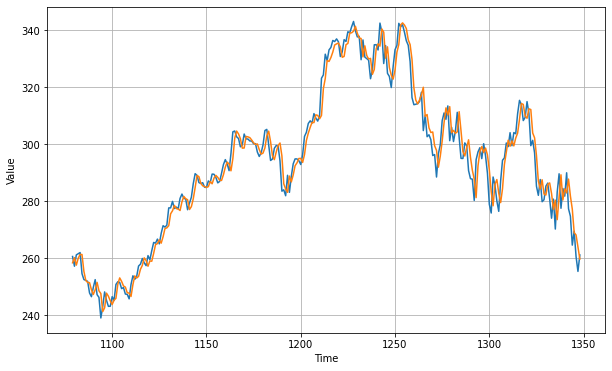

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [14]:
err = keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

print("Todays predicted close for "+ticker+": $", cnn_forecast[-1], " MSE: ",err)

Todays predicted close for MSFT: $ 259.70868  MSE:  3.7702851
